In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from scipy.interpolate import RegularGridInterpolator, splrep, splev
import healpy as hp
from settings import *

# Ple$\nu$m calculation

### local coordinates

In [4]:
coords = {
    'IceCube': {"lon": 0*u.deg, "lat": -90*u.deg},
    'P-ONE': {"lon": -123.3656*u.deg, "lat": 48.4284*u.deg},
    'KM3NeT': {"lon": (16 + 6/60)*u.deg, "lat": (36 + 16/60)*u.deg},
    'Baikal-GVD': {"lon": 108.1650*u.deg, "lat": 53.5587*u.deg}
}

# Get the detection efficiency from the public mc table

In [5]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), 
    np.log(flux_def['numu_conv'])
)

print(livetime)
print(gamma_astro)
print(phi_astro)

315567360.0
-2.37
1.3600000000000003e-18


In [6]:
# show the public detection efficiency 
d_public = np.genfromtxt(
    '../icecube_10year_ps/irfs/IC86_II_effectiveArea.csv',
    skip_header=1
)
# log10(E_nu/GeV)_min log10(E_nu/GeV)_max
# Dec_nu_min[deg] Dec_nu_max[deg]
# A_Eff[cm^2]
emin, emax = np.power(10, [d_public[:,0], d_public[:,1]])
sindec_min, sindec_max = np.sin(np.deg2rad([d_public[:,2], d_public[:,3]]))
# actually it's cos(zen), but we'll just switch the eff area ordering
aeff = d_public[:,4]

emin = np.unique(emin) # all lower energy bounds
emax = np.unique(emax) # all upper energy bounds
ebins = np.unique([emin, emax]) # all bin edges in order
sindec_min = np.unique(sindec_min) # all lower sindec bounds
sindec_max = np.unique(sindec_max) # all upper sindec bounds
sindec_bins = np.unique([sindec_min, sindec_max]) # all bin edges in order
ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = calc_mids(ra_bins)
ra_width = ra_bins[1:] - ra_bins[:-1]

aeff_2d = dict()
# re-shape into 2D array with (A(E) x A(delta))
# and switch the eff area ordering
aeff_2d["icecube_full"] = aeff.reshape(len(sindec_min), len(emin)).T

emids = calc_mids(ebins)
ewidth = emax - emin
sindec_mids = calc_mids(sindec_bins)
sindec_width = sindec_max - sindec_min

print(len(emin), "log_10(energy) bins")
print(len(sindec_min), "declination bins")

# cut at delta > -5deg
min_idx = np.searchsorted(sindec_mids, np.sin(np.deg2rad(-5)))
print(f"Below {np.rad2deg(np.arcsin(sindec_min[min_idx])):1.2f}deg aeff is 0")
aeff_2d["icecube"] = np.copy(aeff_2d["icecube_full"])
aeff_2d["icecube"][:,:min_idx] = 0

# grid for MCEq flux evaluation
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

# some event numbers for checking
det = "icecube"
aeff_factor = (aeff_2d[det] * sindec_width).T * ewidth * livetime * np.sum(ra_width)
astro_ev = aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro
atm_ev = aeff_factor * spl_vals
print(det)
print("conv events:", np.sum(atm_ev))
print("astro events:", np.sum(astro_ev))

40 log_10(energy) bins
50 declination bins
Below -4.59deg aeff is 0
icecube
conv events: 642904.6426454504
astro events: 2799.9769021037205


## Idea: transform the integration over R.A. per sin(dec) into local coordinates

IceCube
P-ONE
KM3NeT
Baikal-GVD


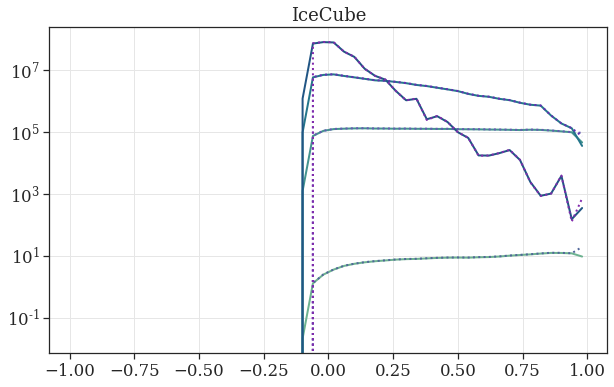

In [7]:
#%%timeit

# Interpolated grid of the effective area in "local" coordinates
# (= icecube's native coordinates)
grid2d = [RegularGridInterpolator(
    (np.arcsin(sindec_mids), ra_mids), # transform dec to local theta
    # switch back to local zenith, add ra as new axis and normalize accordingly
    aeff_2d["icecube"][i][::-1,np.newaxis] / np.atleast_2d(ra_width)/ len(ra_mids),
    method='linear',
    bounds_error=False,
    fill_value=0.
) for i in range(len(emids))]
# grid elements are calculated for each energy bin, grid is theta x phi

# coordinate grid in equatorial coordinates (icrs)
# these will be the integration coordinates
pp, tt = np.meshgrid(ra_mids, np.arcsin(sindec_mids))
eq_coords = SkyCoord(
    pp * u.radian,
    tt * u.radian,
    frame="icrs"
)

aeff_i = {}
factor = 10 # for plotting energy slices

# loop over detectors
for k, coord in coords.items():
    print(k)
    # local detector
    loc = EarthLocation(
        lat=coord["lat"],
        lon=coord["lon"],
    )
    # arbitrary time, doesnt matter here
    time = Time('2021-6-21 00:00:00')
    # transform integration coordinates to local frame
    local_coords = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    # sum up the contributions over the transformed RA axis per declination 
    
    # loop over the energy bins to get the same shape of aeff as before
    # sum along transformed ra coordinates
    aeff_i[k] = np.array([np.sum(
        grid2d[i]((local_coords.alt.rad, local_coords.az.rad)) * ra_width, # integrate over RA
        axis=1) for i in range(len(emids))])
    if k=="IceCube":
        # make a cross check plot
        plt.figure(figsize=(10, 6))
        plt.yscale("log")
        plt.title(k)
        for ie, ae in enumerate(aeff_i[k][::factor]):
            line = plt.plot(
                sindec_mids,
                ae,
                label=f"{emids[ie*factor]:1.1e} GeV",
                ls="-", # rotated
                lw=2
            )
            plt.plot(
                sindec_mids, aeff_2d["icecube"][ie*factor],
                ls=":", # original
                color=slightly_change_color(line[0].get_color(), amount=0.2),
                lw=2
            )


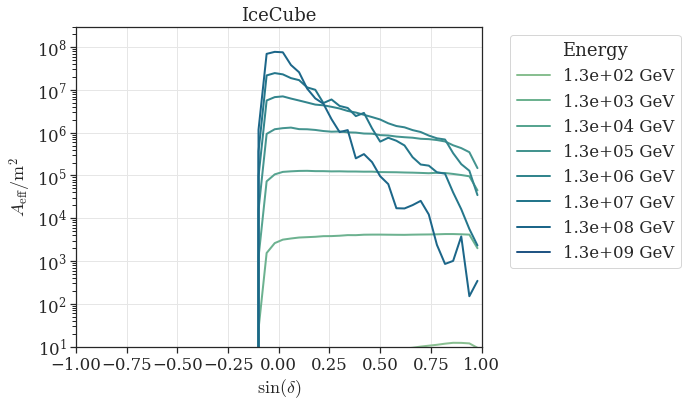

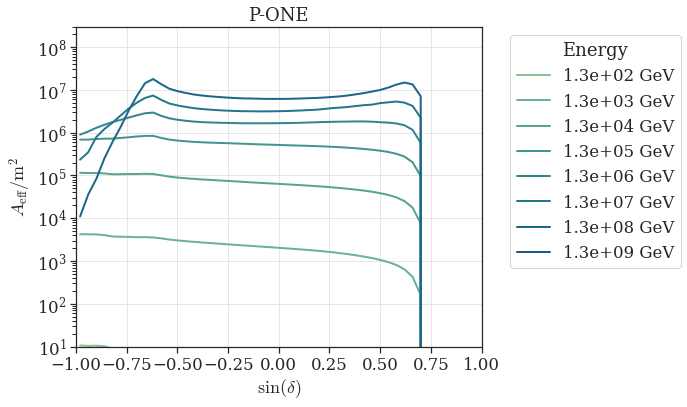

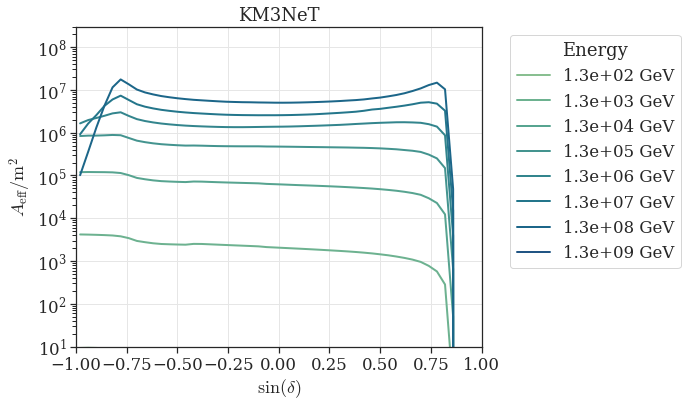

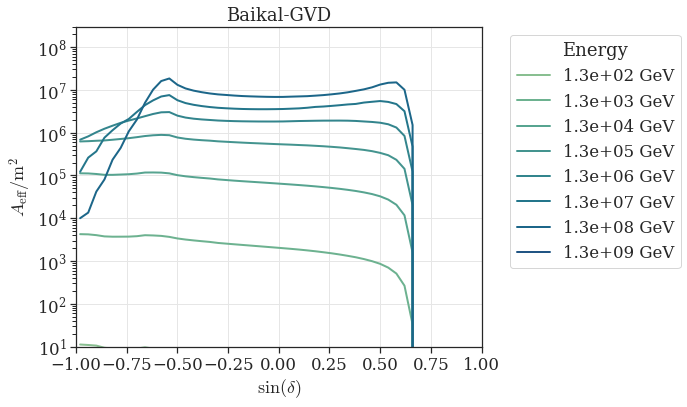

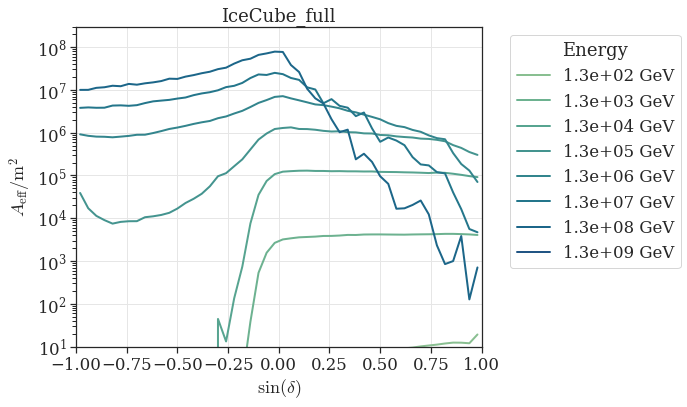

In [15]:
factor = 5
nlines = len(emids) // factor + 1
reset_palette(nlines)
mid_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][nlines // 2]
aeff_i["Plenum"] = np.zeros_like(aeff_i["IceCube"])
for k in aeff_i:
    if k=="Plenum": continue
    aeff_i["Plenum"] += aeff_i[k]
    plt.figure(figsize=(10, 6))
    for ie, ae in enumerate(aeff_i[k][::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV",
            ls="-", # rotated
            lw=2
        )
        #if k=="IceCube":
        #    plt.plot(
        #        sindec_mids, aeff_2d["icecube"][ie*factor],
        #        ls=":", # original
        #        color=slightly_change_color(line[0].get_color(), amount=0.2),
        #        lw=2
        #    )
    plt.yscale("log")
    plt.title(k)
    #if k=="IceCube":
    #    lines = [
    #        matplotlib.lines.Line2D(
    #            [0],
    #            [0],
    #            color=slightly_change_color(mid_color),
    #            linestyle=":"
    #        ),
    #        matplotlib.lines.Line2D(
    #            [0],
    #            [0],
    #            color=mid_color,
    #            linestyle="-")
    #    ]
    #    labels = ['original', 'rotated']
    #    lg = plt.legend(lines, labels, title="Cross check")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Energy")
    #if k=="IceCube":
    #    ax = plt.gca()
    #    ax.add_artist(lg)                
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(10, 3E8)
    plt.xlabel(r"$\sin(\delta)$")
    plt.ylabel(r"$A_{\rm eff}/ {\rm m}^2$")
    plt.tight_layout()
    plt.savefig(f"../plots/{k}_alt_aeff.pdf")


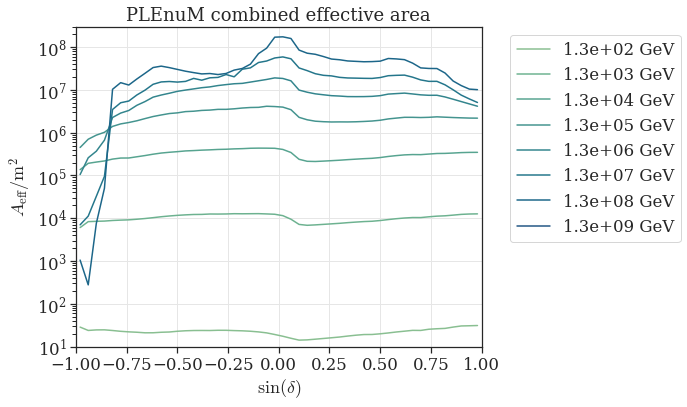

In [19]:
plt.figure(figsize=(10, 6))
for ie, ae in enumerate(aeff_i["Plenum"][::factor]):
    plt.plot(
        sindec_mids[::-1],
        ae,
        label=f"{emids[ie*factor]:1.1e} GeV",
        #label=f"{ebins[ie*factor]:1.1E} - {ebins[ie*factor+1]:1.1E} GeV"
    )
plt.yscale("log")    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.title("PLEnuM combined effective area")
plt.xlim(-1, 1)
plt.xlabel(r"$\sin(\delta)$")
plt.ylabel(r"$A_{\rm eff}/ {\rm m}^2$")
plt.ylim(10, 3E8)
plt.tight_layout()
plt.savefig(f"../plots/Plenum_alt_aeff.pdf")

## save to disc

In [10]:
### add icecube's full effective area
aeff_i["IceCube_full"] = aeff_2d["icecube_full"]

In [16]:
with open("../resources/tabulated_logE_sindec_aeff.pckl", "wb") as f:
    pickle.dump((np.log10(ebins), sindec_bins, aeff_i), f)

### compare to fig1 in https://arxiv.org/abs/1609.04981, looks good
### average over sindec ranges

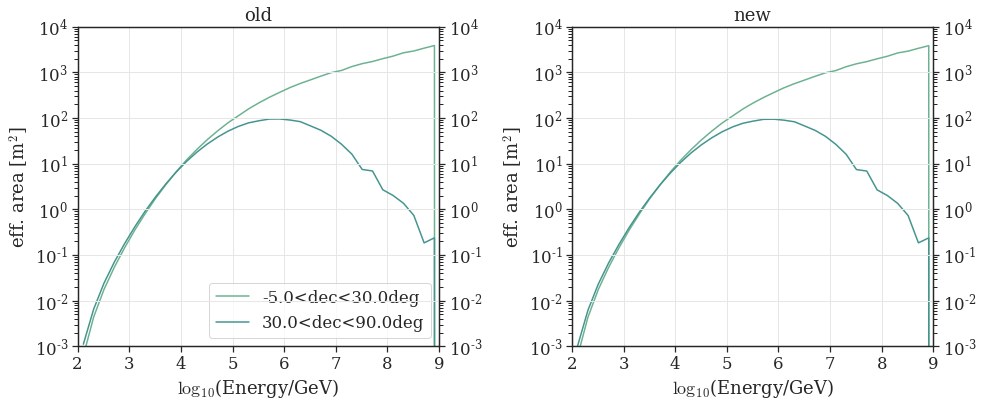

In [111]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6), sharey=False)

def search_ind(sinDec):
    ind = np.argmin(np.abs(sindec_bins - sinDec))
    return ind

decs = np.array([-5, 30, 90])

res_icecube = aeff_2d['icecube'].T
res_new_ic = aeff_i['IceCube'].T

axes[0].set_title('old')
axes[1].set_title('new')

for i, dec in enumerate(decs[:-1]):
    di = np.sin(np.deg2rad(dec))
    mask = np.logical_and(
        sindec_mids > di,
        sindec_mids <= np.sin(np.deg2rad(decs[i+1]))
    )
    axes[0].plot(
        np.log10(emids),
        res_icecube[mask].sum(axis=0) / np.count_nonzero(mask) / 1E4,
        label=r'{:.1f}<dec<{:.1f}deg'.format(decs[i], decs[i+1])
    )

    axes[1].plot(
        np.log10(emids),
        res_new_ic[mask].sum(axis=0) / np.count_nonzero(mask) / 1E4,
        label=r'{:.1f}<dec<{:.1f}deg'.format(decs[i], decs[i+1])
    )
    
for ax in axes:
    ax.set_xlim(2, 9)
    ax.set_ylim(1e-3, 1e4)
    ax.set_yscale('log')
    ax.set_xlabel(r'$\log_{10}$(Energy/GeV)')
    ax.set_ylabel(r'eff. area [m$^2$]')
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax1.set_yscale('log')

axes[0].legend()
fig.tight_layout()
fig.savefig("./plots/comparison_dec_ranges.pdf")

## 2D plots

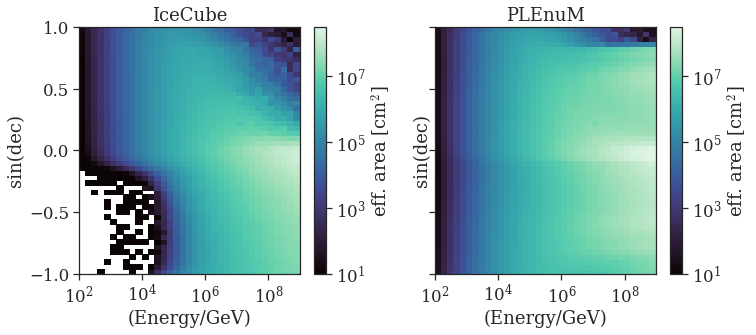

In [21]:
fig, axes=plt.subplots(ncols=2, figsize=(11,5), sharey=True)

ax = axes[0]
ax.set_title('IceCube')
p = ax.pcolormesh(
    ebins,
    sindec_bins, 
    aeff_i['IceCube_full'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=3E8
)
ax.set_xscale("log")
cb = fig.colorbar(p,ax=ax)
cb.set_label(r'eff. area [cm$^2$]')
ax.set_xlim(1E2, 1E9)

ax = axes[1]
ax.set_title('PLEnuM')
p = ax.pcolormesh(
    ebins,
    sindec_bins, 
    aeff_i['Plenum'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=3E8
)
ax.set_xscale("log")
for ax in axes:
    ax.set_xlabel(r'(Energy/GeV)')
    ax.set_ylabel(r'sin(dec)')

cb = fig.colorbar(p,ax=ax)
cb.set_label(r'eff. area [cm$^2$]')
ax.set_xlim(1E2, 1E9)
fig.tight_layout()


# compare with matthias

In [86]:
path = './resources/'
results = np.load(os.path.join(path, 'effective_areas_av_per_day.npy'))
loge_bins = np.linspace(2.,9.,num=25)
e_mids = calc_mids(10**loge_bins)
e_bins = 10**loge_bins
sd_bins = np.linspace(-1.,1.,35)
n_sd, n_e = len(sd_bins)-1, len(e_bins)-1
ebin_width = np.diff(e_bins)

Text(0, 0.5, '$A_{\\rm eff} \\cdot E_\\nu / {\\rm m^2 GeV}$')

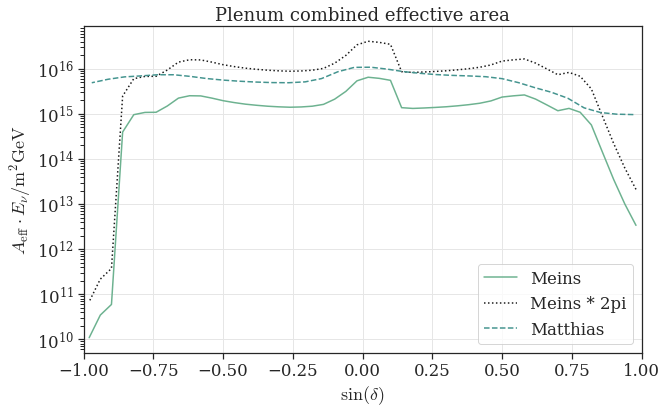

In [91]:
plt.figure(figsize=(10, 6))

plt.plot(
    sindec_mids[::-1],
    ((aeff_i["Plenum"] * sindec_width).T * ewidth).sum(axis=1),
    label="Meins"
)
plt.plot(
    sindec_mids[::-1],
    ((aeff_i["Plenum"] * sindec_width).T * ewidth).sum(axis=1) * np.pi*2,
    label="Meins * 2pi", ls=":", color="k"
)
plt.plot(
    calc_mids(sd_bins)[::-1],
    ((results['effA_plenum'].reshape(
        (n_sd, n_e)
    ) * ebin_width).T * np.diff(sd_bins)).sum(axis=0),
    label="Matthias",
    ls="--"
)
plt.yscale("log")    
plt.legend(loc=0)
plt.grid(True)
plt.title("Plenum combined effective area")
plt.xlim(-1, 1)
plt.xlabel(r"$\sin(\delta)$")
plt.ylabel(r"$A_{\rm eff} \cdot E_\nu / {\rm m^2 GeV}$")

Text(0, 0.5, '$A_{\\rm eff} \\cdot E_\\nu / {\\rm cm^2 GeV}$')

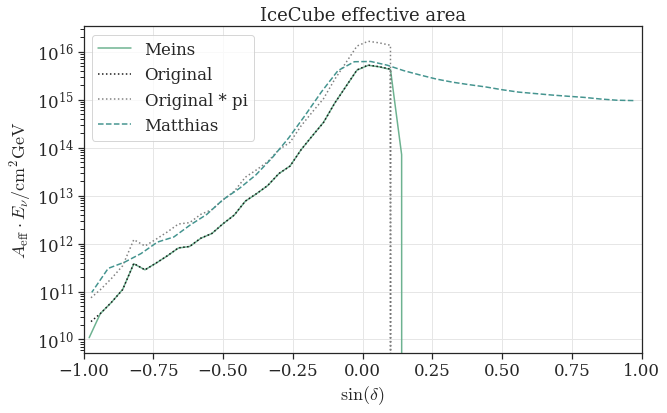

In [95]:
plt.figure(figsize=(10, 6))

plt.plot(
    sindec_mids[::-1],
    ((aeff_i["IceCube"] * sindec_width).T * ewidth).sum(axis=1),
    label="Meins"
)
plt.plot(
    sindec_mids[::-1],
    ((aeff_2d["icecube"] * sindec_width).T * ewidth).sum(axis=1),
    label="Original", ls=":", color="k"
)
plt.plot(
    sindec_mids[::-1],
    ((aeff_2d["icecube"] * sindec_width).T * ewidth).sum(axis=1) * np.pi,
    label="Original * pi", ls=":", color="gray"
)
plt.plot(
    calc_mids(sd_bins)[::-1],
    ((results['effA_icecube'].reshape(
        (n_sd, n_e)
    ) * ebin_width).T * np.diff(sd_bins)).sum(axis=0),
    label="Matthias",
    ls="--"
)
plt.yscale("log")    
plt.legend(loc=0)
plt.grid(True)
plt.title("IceCube effective area")
plt.xlim(-1, 1)
plt.xlabel(r"$\sin(\delta)$")
plt.ylabel(r"$A_{\rm eff} \cdot E_\nu / {\rm cm^2 GeV}$")